In [1]:
import time
import os
import shutil
import sys
import h5py
import tensorflow                     as tf
import numpy                                  as np
import seaborn                                as sns
import pandas                                 as pd
import numpy.random                           as random
from sklearn.utils                        import shuffle
from sklearn.model_selection              import train_test_split
from tqdm                                 import tqdm
from os                                   import path
import pysftp                                 as sftp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

LocalFlg         = 'False'
if (not LocalFlg):
    WORKSPACE_PATH = "/home/venturi/WORKSPACE/"
    IP             = '128.174.245.172'
    User           = "venturi"
else:
    WORKSPACE_PATH = os.getenv('WORKSPACE_PATH')  
    
import matplotlib                             as mpl
import matplotlib.pyplot                      as plt
plt.style.use(WORKSPACE_PATH+'/SurQCT/surqct/scripts/postprocessing/presentation.mplstyle')

import random                                 as rnd

print("="*50)
print(" TensorFlow version: {}".format(tf.__version__))
print(" Eager execution: {}".format(tf.executing_eagerly()))

 TensorFlow version: 2.4.1
 Eager execution: True


In [2]:
pd.set_option('display.max_columns', None)  
sns.set_style('ticks')
plt.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']
# plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{tikz} \usepackage[utf8]{inputenc}')
plt.rc('font', family='Times')
sns.set_context("paper")

# Tick parameters
plt.rcParams['xtick.labelsize'] = 35
plt.rcParams['ytick.labelsize'] = 35
mpl.rcParams['xtick.major.size'] = 20
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 2

plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 35
plt.rcParams['legend.fontsize'] = 30

<ipython-input-2-b1fd6fda0195>:4: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']


In [3]:
Dimension   = 'nondim'
InelRunNb   = 9
ExchRunNb   = 6
DissRunNb   = 55
ReactionFlgQCT    = '2_1_1_0'
ReactionFlgSurQCT = '2_1_1_0'
SaveFigures = False

RatesType           = 'KDiss'
NNRunIdx            = 55
TTranVec            = [1500, 2500, 5000, 6000, 8000, 10000, 12000, 15000, 20000]

import Initialize_System
import Initialize_Paths as Paths

SystName    = 'O3_UMN'
Initialize = getattr(Initialize_System,'Initialize_'+SystName)
System = Initialize()

QCT_ME_path    = Paths.Workspace_path + 'Air_Database/' + System.QCTMEPath
SurQCT_ME_path = Paths.Workspace_path + 'Air_Database/Run_0D_surQCT/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

Data_ME_path   = Paths.Surqct_path + '0D/Data/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'
Figure_ME_path = Paths.Surqct_path + '0D/Figures/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

SurQCTFldr          = Paths.Workspace_path + '/SurQCT/surqct/'
PathToRunFld        = SurQCTFldr + '/../' + RatesType + '/all_temperatures/' 

try:
    os.makedirs(Figure_ME_path)
except OSError as e:
    pass

print('QCT Master Equation Path    :', QCT_ME_path)
print('SurQCT Master Equation Path :', SurQCT_ME_path)
print('Data Master Equation Path   :', Data_ME_path)
print('Figures Master Equation Path:', Figure_ME_path)

QCT Master Equation Path    : /home/venturi/WORKSPACE/Air_Database/Run_0D/
SurQCT Master Equation Path : /home/venturi/WORKSPACE/Air_Database/Run_0D_surQCT/nondim_RunI9_E6_D55/
Data Master Equation Path   : /home/venturi/WORKSPACE/SurQCT/0D/Data/O3_UMN/nondim_RunI9_E6_D55/
Figures Master Equation Path: /home/venturi/WORKSPACE/SurQCT/0D/Figures/O3_UMN/nondim_RunI9_E6_D55/


In [4]:
print("\n[SurQCT]: Loading Modules and Functions ...")

sys.path.insert(0, SurQCTFldr  + '/src/Reading/')
from Reading  import read_levelsdata, read_diatdata

InputFld = PathToRunFld + '/Run_' + str(NNRunIdx) + '/'
print(InputFld)
sys.path.insert(0, InputFld)

print("\n[SurQCT]: Keep Loading Modules and Functions...")
from SurQCT_Input import inputdata

print("\n[SurQCT]: Initializing Input ...")
InputData    = inputdata(WORKSPACE_PATH, SurQCTFldr)

Prefix                    = 'Run_'
InputData.NNRunIdx        = NNRunIdx
InputData.PathToRunFld    = InputData.PathToRunFld+'/'+Prefix+str(InputData.NNRunIdx)
InputData.PathToFigFld    = InputData.PathToRunFld+'/'+InputData.PathToFigFld
InputData.PathToParamsFld = InputData.PathToRunFld+'/'+InputData.PathToParamsFld
InputData.PathToDataFld   = InputData.PathToRunFld+'/Data/'                                                               
InputData.PathToParamsFld = InputData.PathToRunFld+'/Params/'

print("\n[SurQCT]: Loading Final Modules ... ")

sys.path.insert(0, SurQCTFldr  + '/src/Model/' + InputData.ApproxModel + '/')
from Model import model


InputData.DefineModelIntFlg  = 0
InputData.TrainIntFlg        = 0
InputData.TransferFlg        = False
NN_KDiss                     = model(InputData, InputData.PathToRunFld, None, None)
NN_KDiss.load_params(InputData.PathToParamsFld)

OtherVar           = InputData.OtherVar
xVarsVec_i         = InputData.xVarsVec_i + ['vqn','jqn']
xVarsVec           = list(set(xVarsVec_i))
print('[SurQCT]:   Reading Variables: ', xVarsVec)

InputData.MultFact = 1.e+8
MinValueTrain      = 1.e-18 * InputData.MultFact
MinValueTest       = 1.e-18 * InputData.MultFact

NMolecules         = len(InputData.PathToLevelsFile)

LevelsData = []
DiatData   = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(InputData.PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(InputData.PathToDiatFile[iMol], InputData.Molecules[iMol], np.array(TTranVec), np.array(TTranVec))
    DiatData.append(DiatDataTemp)

    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)
    


[SurQCT]: Loading Modules and Functions ...
/home/venturi/WORKSPACE//SurQCT/surqct//../KDiss/all_temperatures//Run_55/

[SurQCT]: Keep Loading Modules and Functions...

[SurQCT]: Initializing Input ...

[SurQCT]: Loading Final Modules ... 
[SurQCT]:   Variables Selected for Training:
[SurQCT]:     x =  ['ECB_i', 'ro_i', 'rMax_i', 'TTran_i']
[SurQCT]:     y =  KDiss
[SurQCT]:   Loading ML Model from Folder: /home/venturi/WORKSPACE//SurQCT/surqct//../KDiss/all_temperatures//Run_55/MyModel
[SurQCT]:   Loading ML Model Parameters from File:  /home/venturi/WORKSPACE//SurQCT/surqct//../KDiss/all_temperatures//Run_55/Params//ModelCheckpoint/cp-46260.ckpt
[SurQCT]:   Reading Variables:  ['vqn', 'ECB', 'jqn', 'rMax', 'ro']
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/O2_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/O2/UMN/FromUMN_Sorted.inp
[SurQCT]

In [5]:
def read_kdissdata(InputData, PathToHDF5File, TTra, TInt, NProcTypes):
    print('[SurQCT]:       Reading HDF5 File from: ' + PathToHDF5File + ' for Excitation Rates at Temperature ' + str(int(TTra)) + 'K')

    HDF5Exist_Flg = path.exists(PathToHDF5File)
    if (HDF5Exist_Flg):
        f = h5py.File(PathToHDF5File, 'a')
    else:
        f = {'key': 'value'}
        
    try:
        TStr  = 'T_' + str(int(TTra)) + '_' + str(int(TInt)) + '/Rates/'
        grp   = f[TStr]
        Data  = grp["Diss"]
        KDiss = Data[...]
        f.close()   

    except:    
        KDiss = None
        
    return KDiss

## Dissociation Rates vs E

[SurQCT]:    TTran =  1500
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 1500K
[SurQCT]:    TTran =  2500
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 2500K
[SurQCT]:    TTran =  5000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 5000K
[SurQCT]:    TTran =  6000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 6000K
[SurQCT]:    TTran =  8000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 8000K
[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for

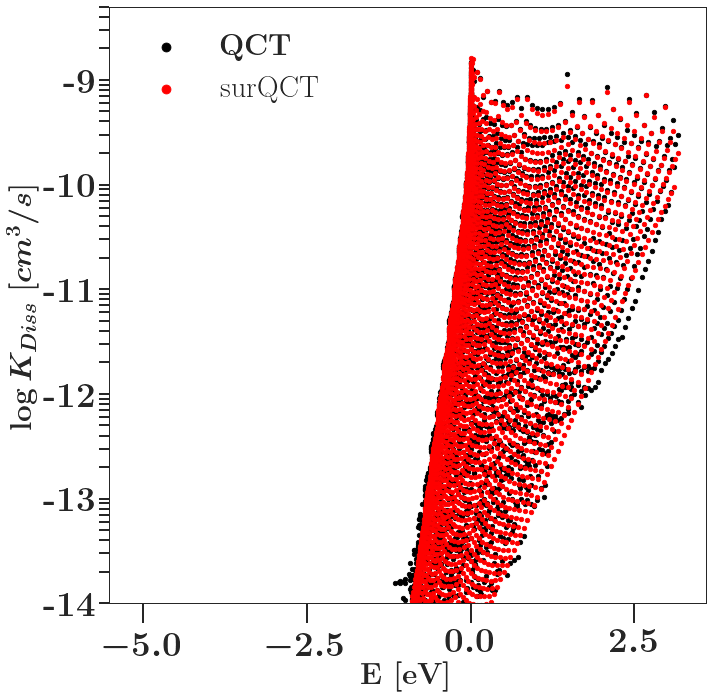

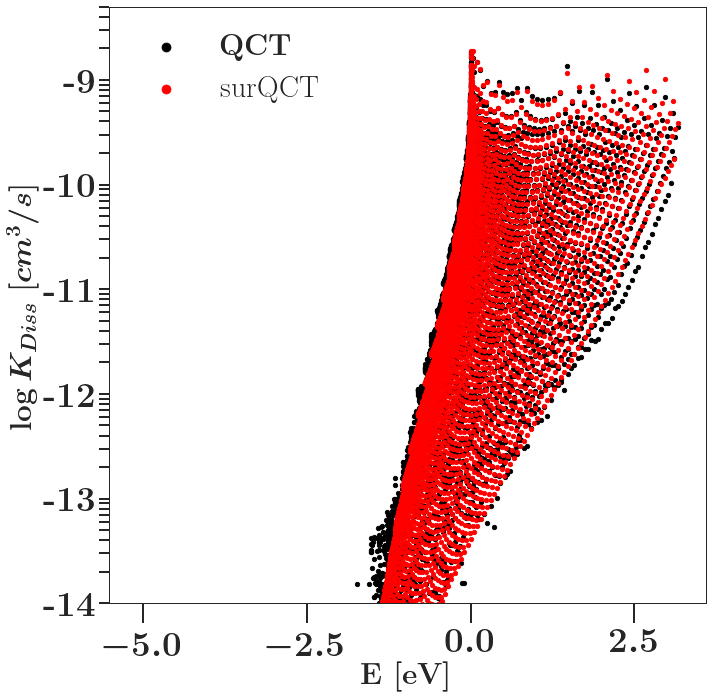

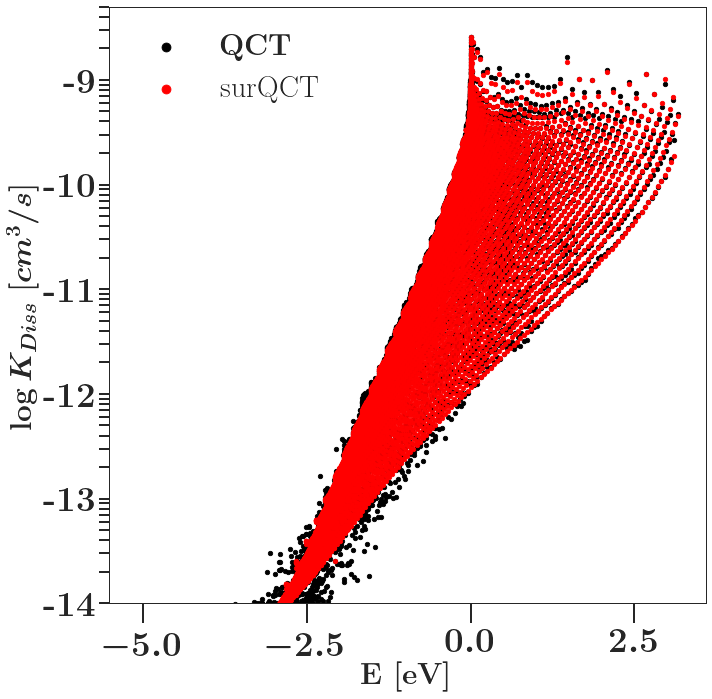

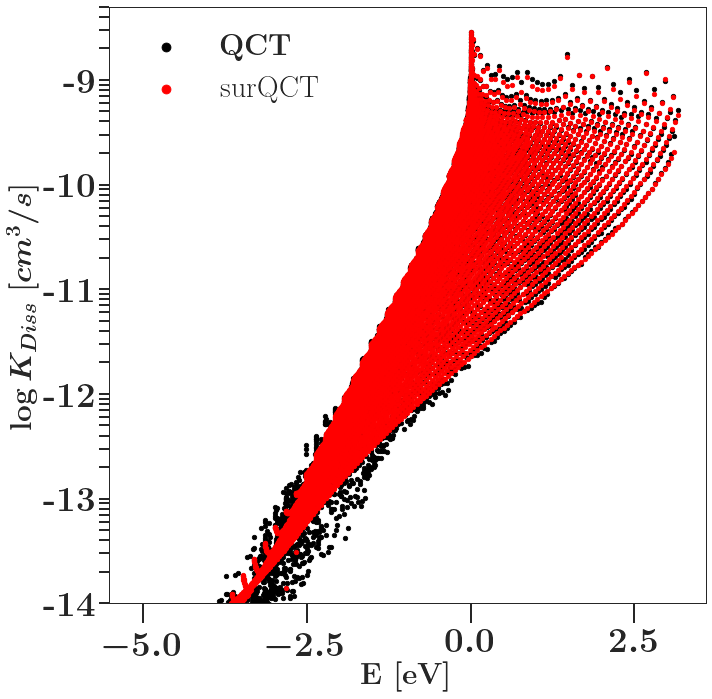

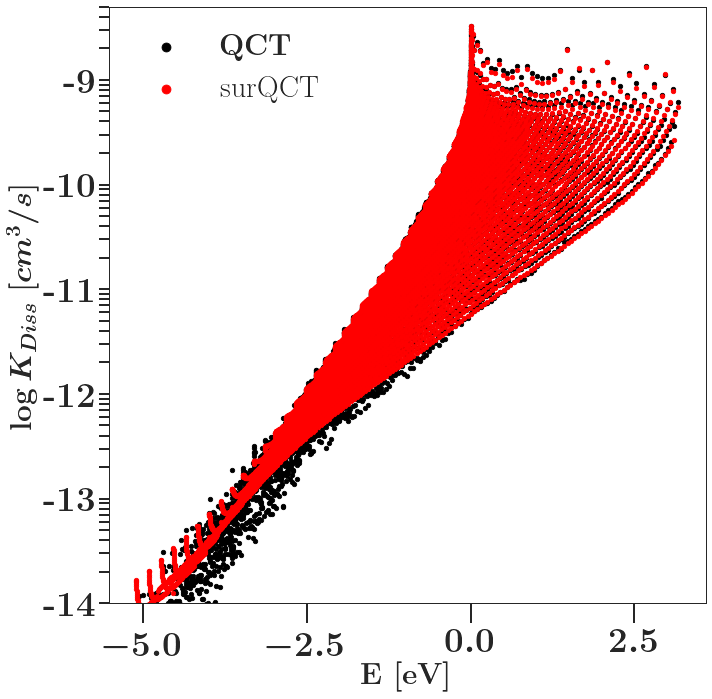

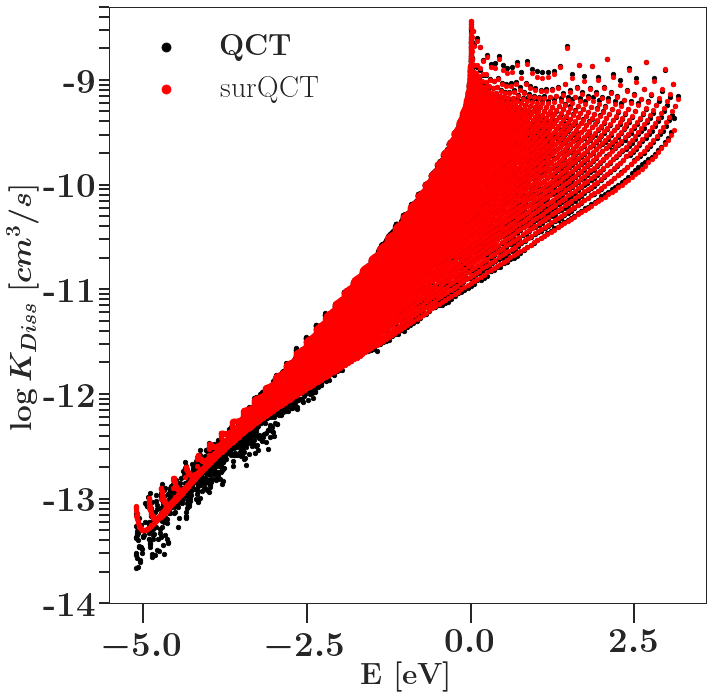

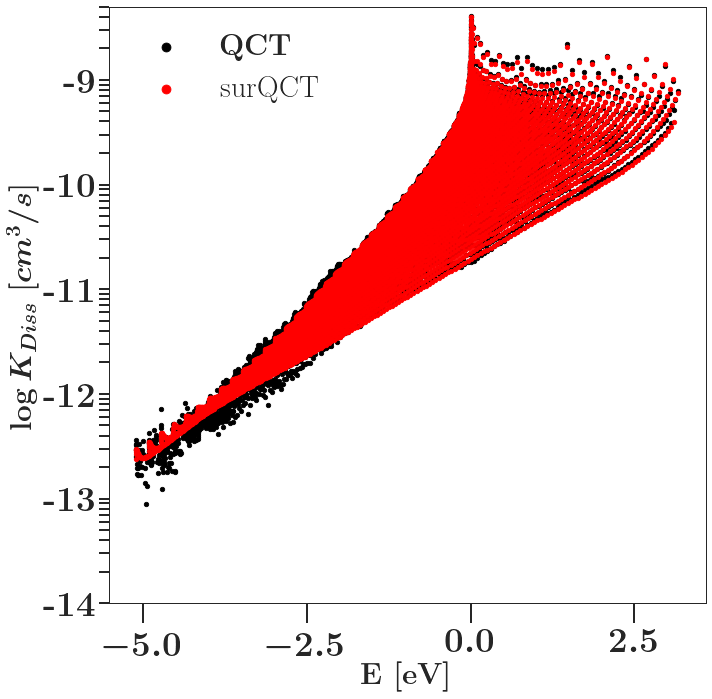

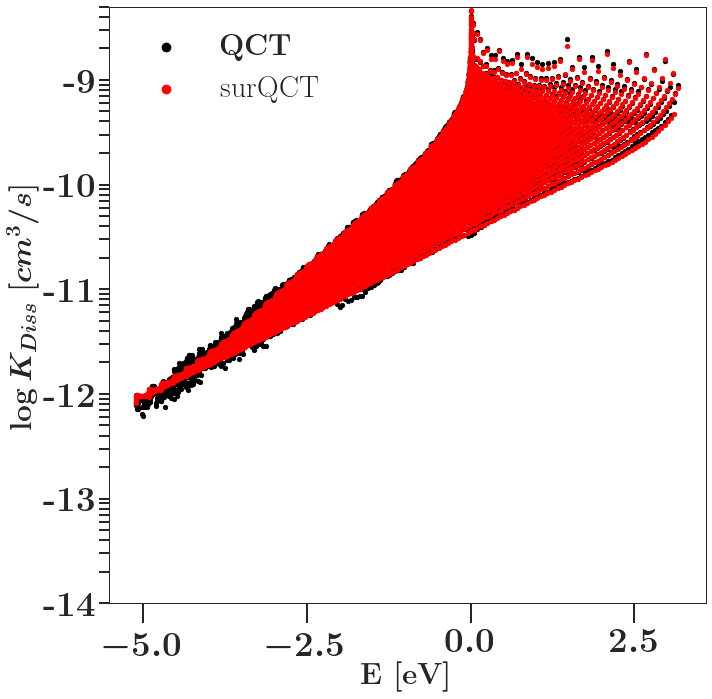

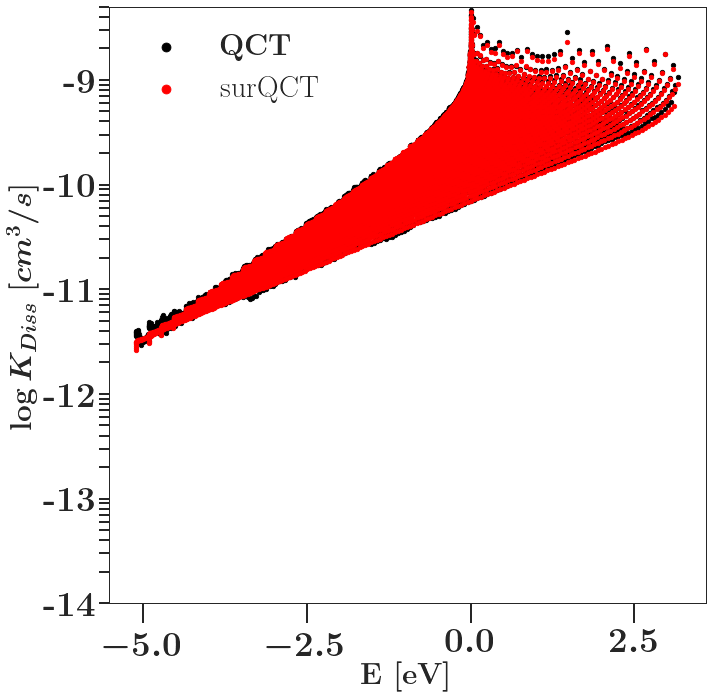

In [55]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator,LogLocator)

for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, InputData.PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec


    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    
    ### Plotting
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    
    ecb_color = LevelsData[0]['ECB'].to_numpy()
    cmap=mpl.colors.ListedColormap(["k","slategray","sandybrown","sienna","gold","y","yellowgreen","g","limegreen","r","mediumvioletred","b","c","cyan"])
    
    if (KDissAll is not None):
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=20, c='k',label='\\textbf{QCT}')
    ax.scatter(DiatData[1]['EInt'], KDiss_NN,   s=20, c='r',label='surQCT')

    # x-axis properties
    plt.xlabel('\\textbf{E [eV]}')
    ax.set_xticks([-5,-2.5,0,2.5])
    
    # y-axis properties
    plt.yscale('log')
    plt.ylim([1.e-14, 5.e-9])    
    plt.ylabel('$\log{K_{Diss}}$ \\textbf{[}$cm^3/s$\\textbf{]}')
    ax.set_yticks([1.e-14,1.e-13,1e-12,1.e-11,1.e-10,1.e-9])
    ax.set_yticklabels(['\\textbf{-14}','\\textbf{-13}','\\textbf{-12}','\\textbf{-11}','\\textbf{-10}','\\textbf{-9}'])
    
    plt.legend(frameon=False,markerscale=2.0)
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    fig.tight_layout(pad=1.5) 
    if(SaveFigures):
        plt.savefig((Figure_ME_path+System.Name+'_T'+str(TTran)+'K_KDiss.eps'), format='eps')

## Dissociation rates vs E, zoomed in, 2 Temperatures side by side

[SurQCT]:    TTran =  6000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 6000K
[SurQCT]:    TTran =  8000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 8000K
[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 10000K


IndexError: index 2 is out of bounds for axis 0 with size 2

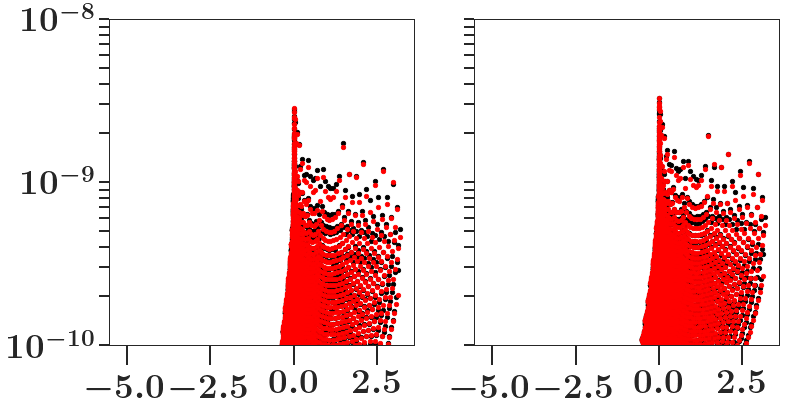

In [8]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator,LogLocator)

fig,ax = plt.subplots(1,2,figsize=(12,6),sharey=True)
iplot = 0
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, InputData.PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec


    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    
    ### Plotting
    if (KDissAll is not None):
        ax[iplot].scatter(DiatData[1]['EInt'], KDissAll[:,0], s=20, c='k',label='\\textbf{QCT}')
    ax[iplot].scatter(DiatData[1]['EInt'], KDiss_NN,   s=20, c='r',label='\\textbf{surQCT}')

    # x-axis properties
    ax[iplot].set_xticks([-5,-2.5,0,2.5])
    
    # y-axis properties
    plt.yscale('log')
    plt.ylim([1.e-10, 1.e-8])    

    ax[iplot].set_yticks([1.e-10,1.e-9,1.e-8])
    iplot += 1

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xticks([])
plt.yticks([])

plt.xlabel('\\textbf{E [eV]}',labelpad=60)
plt.ylabel('$K_{Diss}$ \\textbf{[}$cm^3/s$\\textbf{]}',labelpad=100)
lines_labels = [ax[i].get_legend_handles_labels() for i in range(iplot-1)]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels,frameon=False,markerscale=2.0,loc = 'upper center',ncol=1,bbox_to_anchor=(0.37, 1.0),handletextpad=0.1)

fig.tight_layout(pad=0.5) 
if(SaveFigures):
    plt.savefig((Figure_ME_path+System.Name+'_KDiss_zoomed.pdf'), format='pdf',dpi=600)

## Correlation Plot for randomly sampled data

In [45]:
# Sample 50 states per temperatures for rates above 1e-15
NIdx = 100
KDiss = []
sampled_levels = []
KDissNN = []

for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    KDissAllTemp = read_kdissdata(InputData, InputData.PathToHDF5File, TTran, TTran, 3)
    Mask = KDissAllTemp > 1.e-15
    iIdxVec = np.arange(NLevels[0])
    sampled_levels_temp = rnd.choices(list(iIdxVec), k=NIdx)
    
    jNLevels = NIdx

    ### FWD Rates
    iiIdxVec              = sampled_levels_temp 

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec


    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NNTemp = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    
    KDiss.append(KDissAllTemp[sampled_levels_temp,0])
    KDissNN.append(KDiss_NNTemp)
    sampled_levels.append(sampled_levels_temp)
    

[SurQCT]:    TTran =  1500
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 1500K
[SurQCT]:    TTran =  2500
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 2500K
[SurQCT]:    TTran =  5000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 5000K
[SurQCT]:    TTran =  6000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 6000K
[SurQCT]:    TTran =  8000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 8000K
[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for

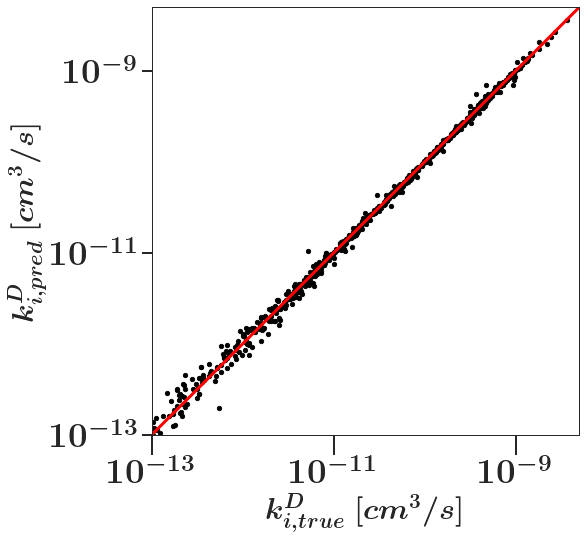

In [52]:
SaveFigures = True
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator,LogLocator)

fig,ax = plt.subplots(1,1,figsize=(8,8),sharey=True)
if (KDiss is not None):
    ax.scatter(KDiss, KDissNN, s=20, c='k',label='\\textbf{QCT}')
    
    ax.plot([1e-13,1e-8],[1e-13,1e-8],'r',linewidth=3.0)
    # axis properties
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([1.e-13, 5.e-9]) 
    plt.ylim([1.e-13, 5.e-9])  
    plt.xticks([1e-13,1e-11,1e-9])
    plt.yticks([1e-13,1e-11,1e-9])

    plt.xlabel('$k^D_{i,true}$ \\textbf{[}$cm^3/s$\\textbf{]}')
    plt.ylabel('$k^D_{i,pred}$ \\textbf{[}$cm^3/s$\\textbf{]}')
    plt.minorticks_off()
    
    aspectratio=1.0
    ax.set_aspect(1.0/1.0, adjustable='box')
    fig.tight_layout(pad=0.5) 
    if(SaveFigures):
        plt.savefig((Figure_ME_path+System.Name+'_T'+str(TTran)+'K_KDissScatter.pdf'), format='pdf',dpi=300)

[SurQCT]:    TTran =  1500
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 1500K
[SurQCT]:    TTran =  2500
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 2500K
[SurQCT]:    TTran =  5000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 5000K
[SurQCT]:    TTran =  6000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 6000K
[SurQCT]:    TTran =  8000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 8000K
[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for

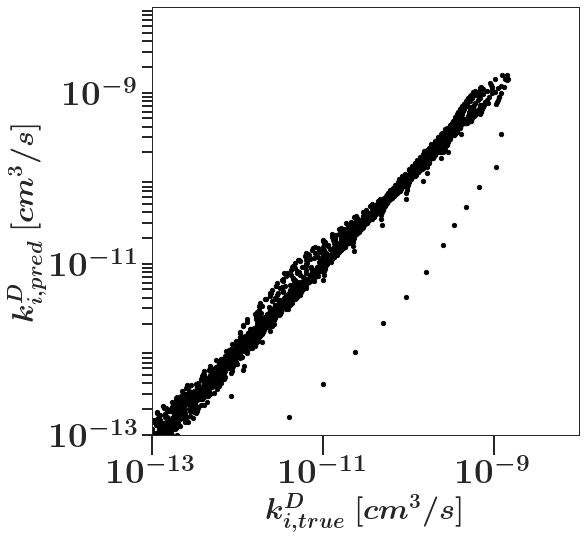

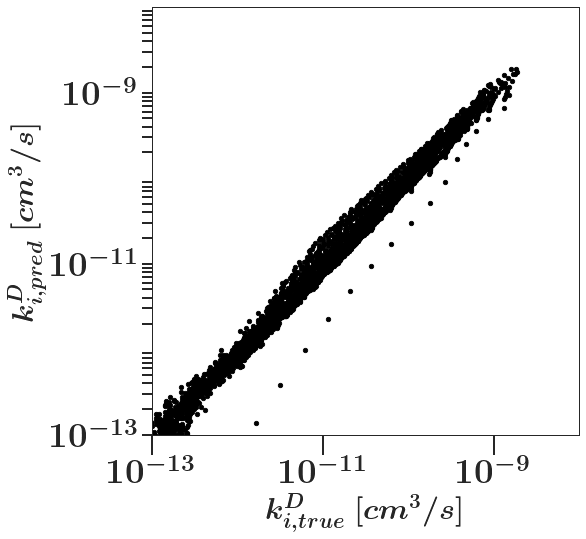

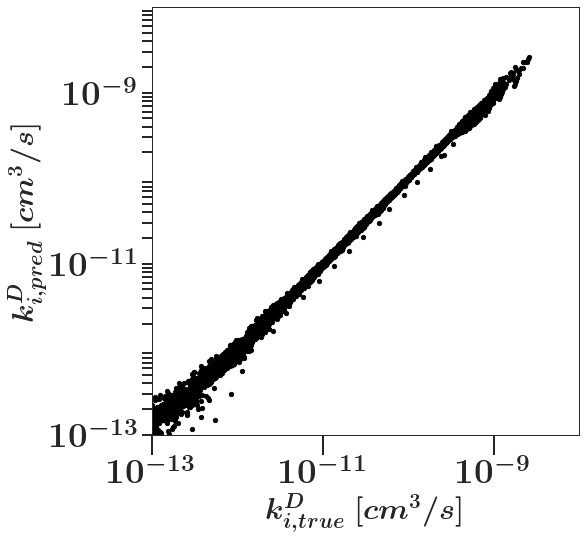

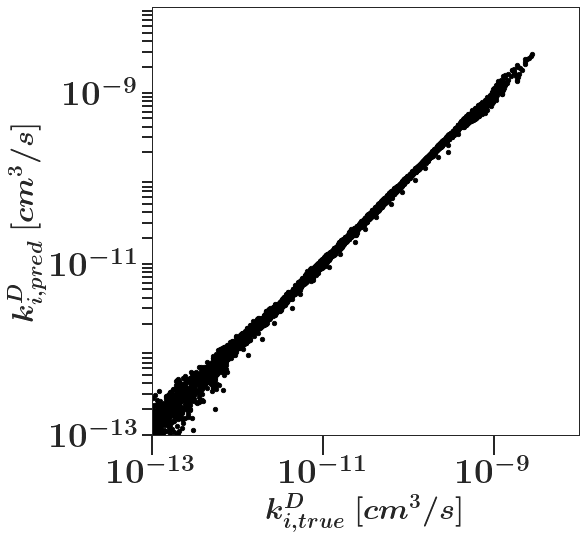

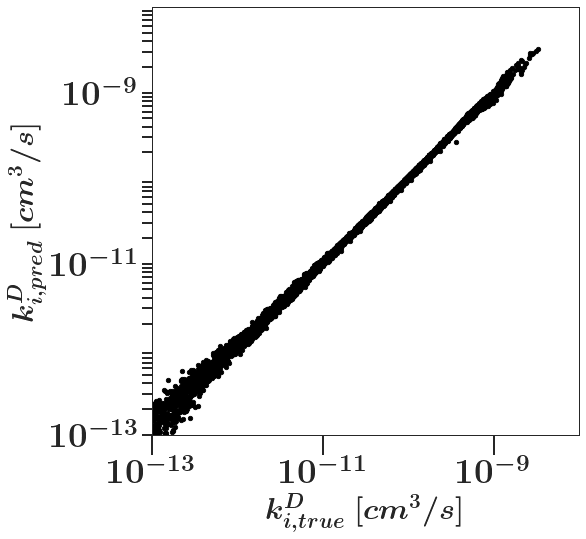

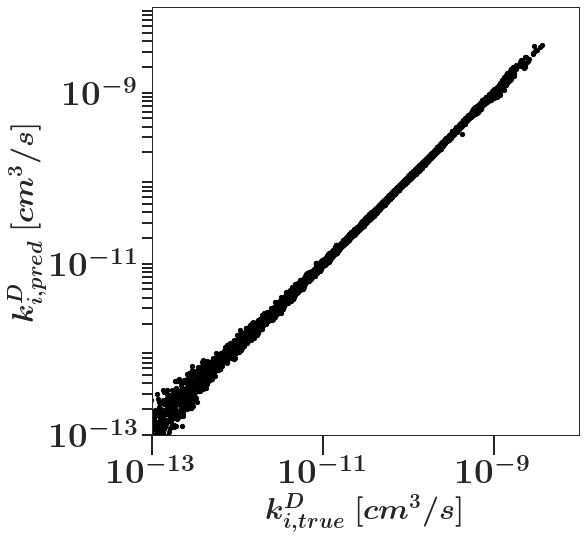

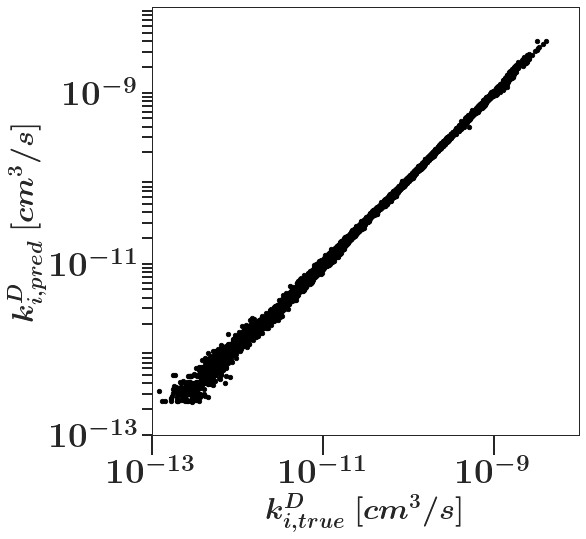

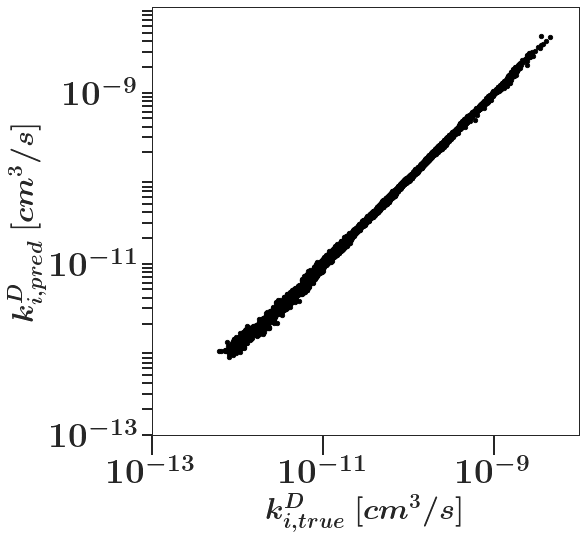

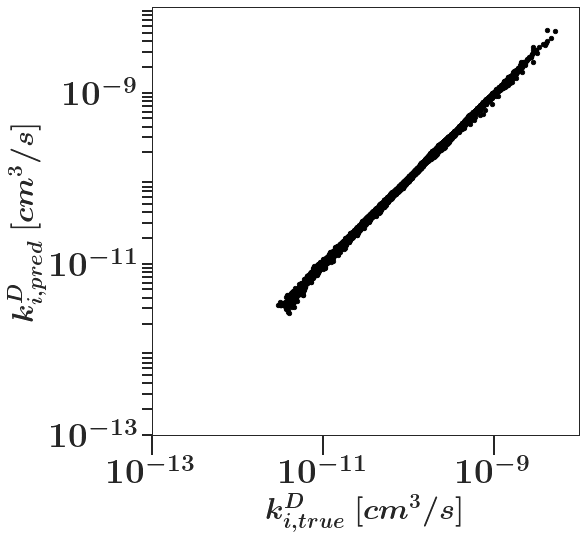

In [53]:
SaveFigures = False

for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    fig,ax = plt.subplots(1,1,figsize=(8,8),sharey=True)

    iplot = 0

    KDissAll = read_kdissdata(InputData, InputData.PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec


    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    
    ### Plotting
    if (KDissAll is not None):
        ax.scatter(KDissAll[:,0], KDiss_NN, s=20, c='k',label='\\textbf{QCT}')
    
    # axis properties
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([1.e-13, 1.e-8]) 
    plt.ylim([1.e-13, 1.e-8])  
    plt.yticks([1e-13,1e-11,1e-9])

    plt.xlabel('$k^D_{i,true}$ \\textbf{[}$cm^3/s$\\textbf{]}')
    plt.ylabel('$k^D_{i,pred}$ \\textbf{[}$cm^3/s$\\textbf{]}')

    aspectratio=1.0
    ax.set_aspect(1.0/1.0, adjustable='box')
    fig.tight_layout(pad=0.5) 
    if(SaveFigures):
        plt.savefig((Figure_ME_path+System.Name+'_T'+str(TTran)+'K_KDissScatter.pdf'), format='pdf',dpi=300)

# Plotting KDiss and Error on diatomic potential

In [6]:
pd.set_option('display.max_columns', None)  
sns.set_style('ticks')
plt.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']
# plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{tikz} \usepackage[utf8]{inputenc}')
plt.rc('font', family='Times')
sns.set_context("paper")

# Tick parameters
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 2

plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 20

<ipython-input-6-f29ba97360a6>:4: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']


[SurQCT]:    TTran =  1500
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 1500K


<ipython-input-56-8dfd6af8c502>:13: RuntimeWarning: divide by zero encountered in log10
  sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=100, c=np.log10(KDissAll[:,0]), vmin=vmin, vmax=vmax,cmap='jet')
<ipython-input-56-8dfd6af8c502>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
<ipython-input-56-8dfd6af8c502>:13: RuntimeWarning: divide by zero encountered in log10
  sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=100, c=np.log10(KDissAll[:,0]), vmin=vmin, vmax=vmax,cmap='jet')
<ipython-input-56-8dfd6af8c502>:38: UserWarning: This figure include

[SurQCT]:    TTran =  2500
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 2500K


<ipython-input-56-8dfd6af8c502>:13: RuntimeWarning: divide by zero encountered in log10
  sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=100, c=np.log10(KDissAll[:,0]), vmin=vmin, vmax=vmax,cmap='jet')
<ipython-input-56-8dfd6af8c502>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[SurQCT]:    TTran =  5000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 5000K


<ipython-input-56-8dfd6af8c502>:13: RuntimeWarning: divide by zero encountered in log10
  sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=100, c=np.log10(KDissAll[:,0]), vmin=vmin, vmax=vmax,cmap='jet')
<ipython-input-56-8dfd6af8c502>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[SurQCT]:    TTran =  6000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 6000K


<ipython-input-56-8dfd6af8c502>:13: RuntimeWarning: divide by zero encountered in log10
  sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=100, c=np.log10(KDissAll[:,0]), vmin=vmin, vmax=vmax,cmap='jet')
<ipython-input-56-8dfd6af8c502>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[SurQCT]:    TTran =  8000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 8000K


<ipython-input-56-8dfd6af8c502>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 10000K


<ipython-input-56-8dfd6af8c502>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[SurQCT]:    TTran =  12000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 12000K


<ipython-input-56-8dfd6af8c502>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[SurQCT]:    TTran =  15000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 15000K


<ipython-input-56-8dfd6af8c502>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[SurQCT]:    TTran =  20000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 20000K


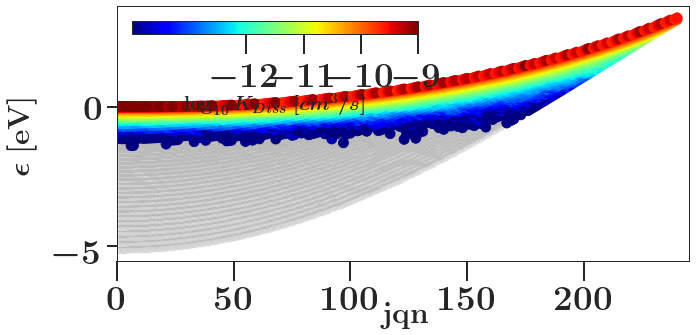

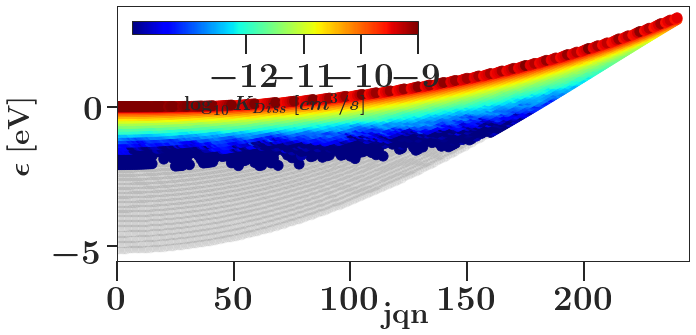

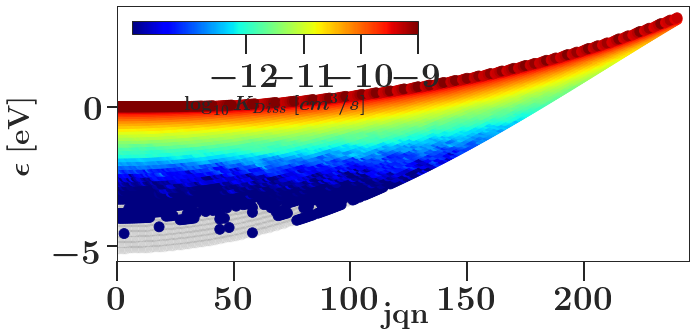

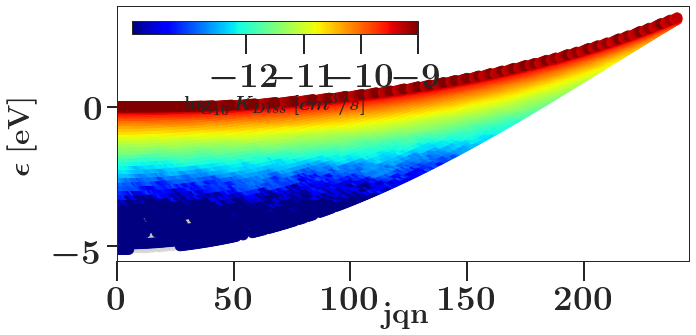

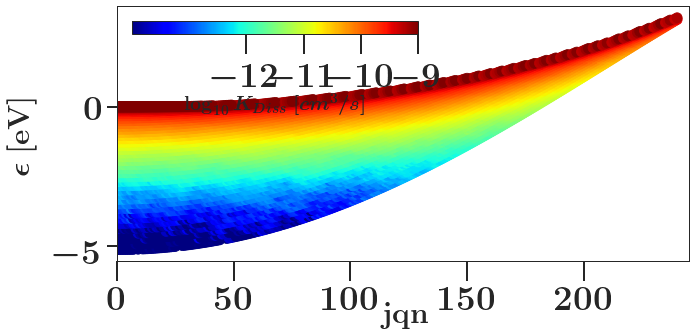

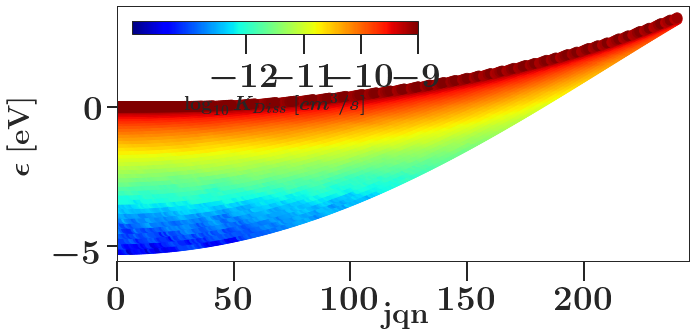

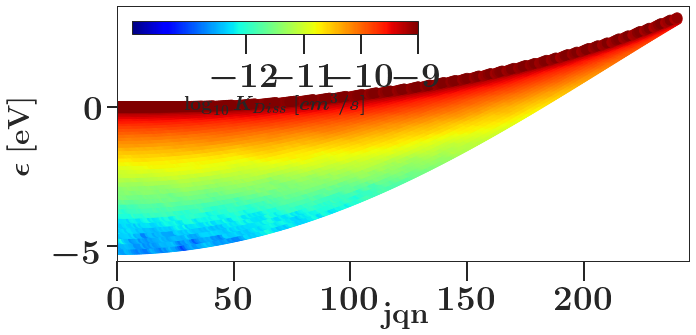

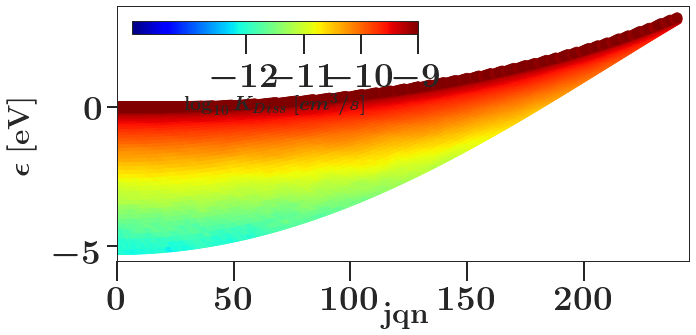

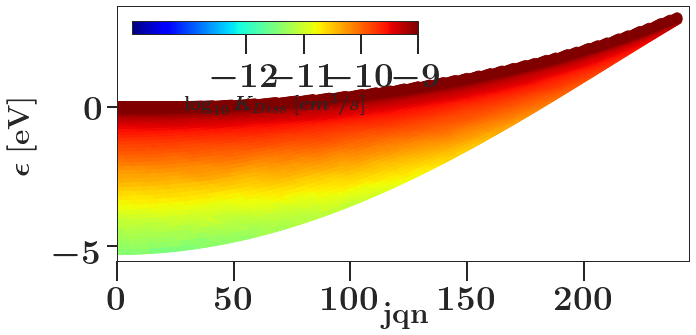

In [56]:
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, InputData.PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    
    
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=50, c='grey',alpha=0.1)

    vmax     = -9
    vmin     = -14

    sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=100, c=np.log10(KDissAll[:,0]), vmin=vmin, vmax=vmax,cmap='jet')
    
    axs.set_xlim([DiatData[1]['jqn'].min(), 245])
#     axs.set_ylim([DiatData[1]['jqn'].min(), 200])
#     axs.set_xticks([0,10,20,30,40])
#     axs.set_yticks([0,25,50,75,100,125,150,175])

    axins1 = inset_axes(axs,
                        width="50%",  # width = 50% of parent_bbox width
                        height="5%",  # height : 5%
                        loc='upper left')
    
    cbar = fig.colorbar(sc, cax=axins1, orientation="horizontal", ticks=[-12,-11,-10,-9])
    axins1.xaxis.set_ticks_position("bottom")    
    cbar.set_label('$\log_{10}{K_{Diss}}$ \\textbf{[}$cm^3/s$\\textbf{]}',fontsize=20)

    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel('\\textbf{jqn}',labelpad=40)
    plt.ylabel('$\epsilon$ \\textbf{[eV]}',labelpad=80)
    
    
    fig.tight_layout(pad=2.0) 
#     plt.savefig(('/home/venturi/WORKSPACE/SurQCT/0D/Figures/OUSD_poster/T'+str(TTran)+'K_KDiss_DiatPot.eps'), format='eps',dpi=600)


[SurQCT]:    TTran =  1500
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 1500K


<ipython-input-57-86ef00622a19>:32: RuntimeWarning: divide by zero encountered in true_divide
  error_Kdiss = np.absolute(KDissAll[:,0] - KDiss_NN)/KDissAll[:,0]
<ipython-input-57-86ef00622a19>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)
<ipython-input-57-86ef00622a19>:32: RuntimeWarning: divide by zero encountered in true_divide
  error_Kdiss = np.absolute(KDissAll[:,0] - KDiss_NN)/KDissAll[:,0]
<ipython-input-57-86ef00622a19>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


[SurQCT]:    TTran =  2500
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 2500K
[SurQCT]:    TTran =  5000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 5000K
[SurQCT]:    TTran =  6000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 6000K


<ipython-input-57-86ef00622a19>:32: RuntimeWarning: divide by zero encountered in true_divide
  error_Kdiss = np.absolute(KDissAll[:,0] - KDiss_NN)/KDissAll[:,0]
<ipython-input-57-86ef00622a19>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)
<ipython-input-57-86ef00622a19>:32: RuntimeWarning: divide by zero encountered in true_divide
  error_Kdiss = np.absolute(KDissAll[:,0] - KDiss_NN)/KDissAll[:,0]
<ipython-input-57-86ef00622a19>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


[SurQCT]:    TTran =  8000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 8000K
[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 10000K


<ipython-input-57-86ef00622a19>:32: RuntimeWarning: divide by zero encountered in true_divide
  error_Kdiss = np.absolute(KDissAll[:,0] - KDiss_NN)/KDissAll[:,0]
<ipython-input-57-86ef00622a19>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)
<ipython-input-57-86ef00622a19>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


[SurQCT]:    TTran =  12000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 12000K
[SurQCT]:    TTran =  15000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 15000K


<ipython-input-57-86ef00622a19>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)
<ipython-input-57-86ef00622a19>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


[SurQCT]:    TTran =  20000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 20000K


<ipython-input-57-86ef00622a19>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


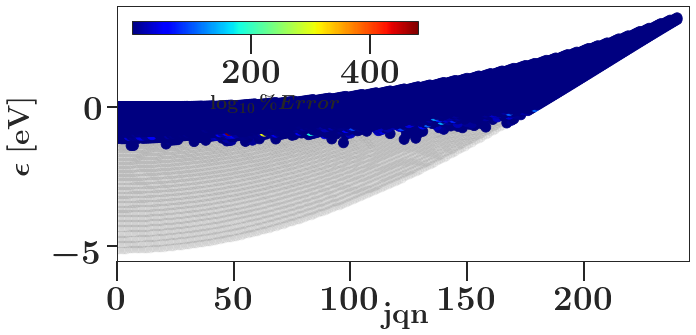

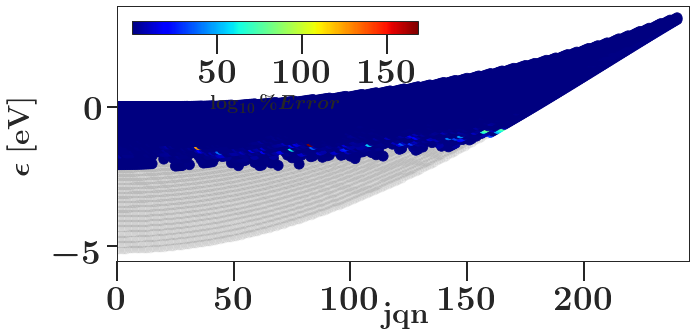

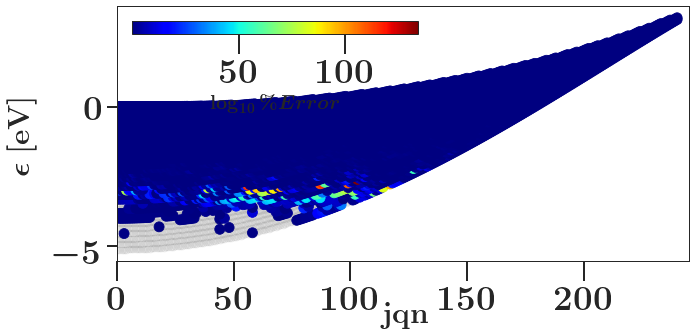

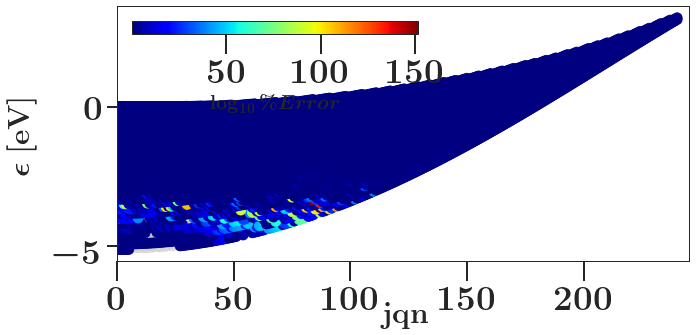

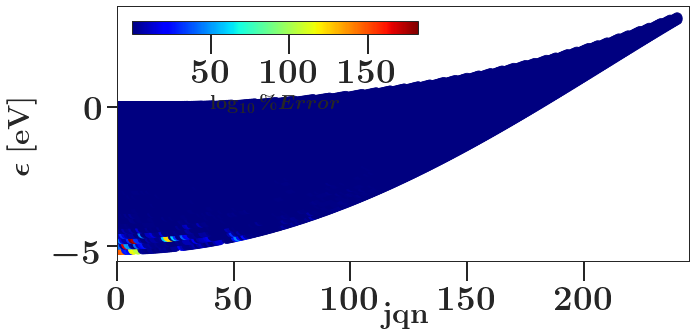

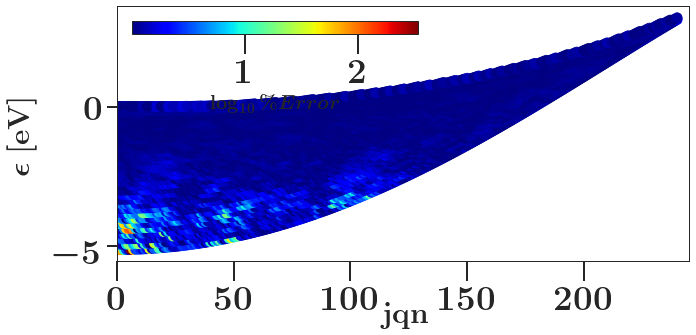

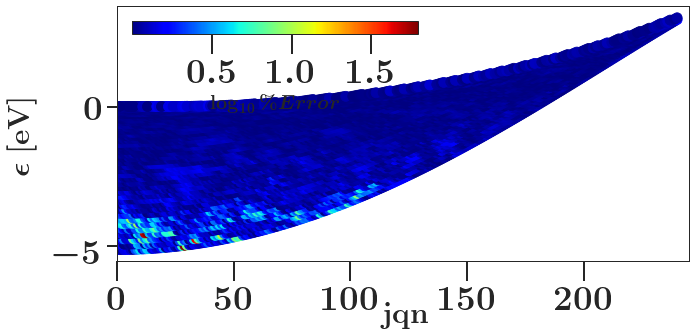

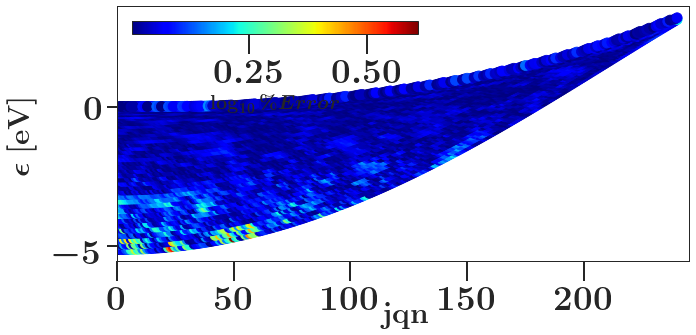

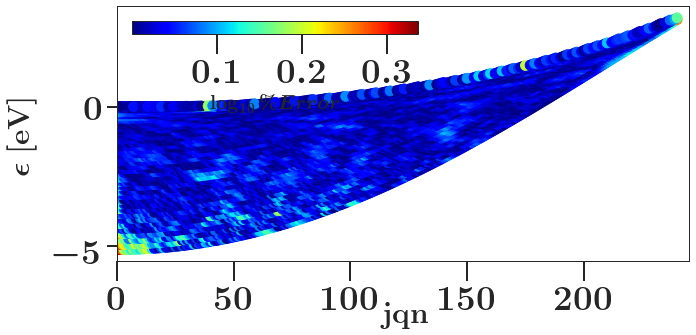

In [57]:
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, InputData.PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec


    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=50, c='grey',alpha=0.1)

#     vmax     = -9
#     vmin     = -20
    
    KDiss_NN = np.reshape(KDiss_NN,[1,6115])
    error_Kdiss = np.zeros([6115,1])
    if (KDissAll is not None):
        error_Kdiss = np.absolute(KDissAll[:,0] - KDiss_NN)/KDissAll[:,0]
    error_Kdiss[error_Kdiss == 0.0] = 'nan'
    
    sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=100, c=(error_Kdiss),cmap='jet')
    
    axs.set_xlim([DiatData[1]['jqn'].min(), 245])
#     axs.set_ylim([DiatData[1]['jqn'].min(), 200])
#     axs.set_xticks([0,10,20,30,40])
#     axs.set_yticks([0,25,50,75,100,125,150,175])

    axins1 = inset_axes(axs,
                        width="50%",  # width = 50% of parent_bbox width
                        height="5%",  # height : 5%
                        loc='upper left')
    
    cbar = fig.colorbar(sc, cax=axins1, orientation="horizontal")
    axins1.xaxis.set_ticks_position("bottom")    
    cbar.set_label('$\log_{10}{\% Error}$',fontsize=20)

    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel('\\textbf{jqn}',labelpad=40)
    plt.ylabel('$\epsilon$ \\textbf{[eV]}',labelpad=80)
    
    
    fig.tight_layout(pad=2.0) 
#     plt.savefig((Figure_ME_path+System.Name+'_KDissError_DiatPot.pdf'), format='pdf',dpi=300)


# N3 KDiss

In [7]:
Dimension   = 'nondim'
InelRunNb   = 9
ExchRunNb   = 6
DissRunNb   = 55
ReactionFlgQCT    = '1_1_1_0'
ReactionFlgSurQCT = '1_1_1_0'

import Initialize_System
import Initialize_Paths as Paths

SystName    = 'N3_NASA'
Initialize = getattr(Initialize_System,'Initialize_'+SystName)
System = Initialize()

TTranVec = [10000, 20000]

QCT_ME_path    = Paths.Workspace_path + 'Air_Database/' + System.QCTMEPath
SurQCT_ME_path = Paths.Workspace_path + 'Air_Database/Run_0D_surQCT/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

Data_ME_path   = Paths.Surqct_path + '0D/Data/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'
Figure_ME_path = Paths.Surqct_path + '0D/Figures/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

print('QCT Master Equation Path    :', QCT_ME_path)
print('SurQCT Master Equation Path :', SurQCT_ME_path)
print('Data Master Equation Path   :', Data_ME_path)
print('Figures Master Equation Path:', Figure_ME_path)


PathToLevelsFile = [WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/N2_LogER_ro_tau_rMax.csv',
                    WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/N2_LogER_ro_tau_rMax.csv']
PathToDiatFile   = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp',
                    WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp']
Molecules        = ['N2', 'N2']
PathToHDF5File   = WORKSPACE_PATH + '/Air_Database/HDF5_Database/N3_NASA.hdf5'
ScalingFact      = 1


#====================================================================
# Reading Levels Info of Initial and Final Molecules
NMolecules         = len(PathToLevelsFile)
LevelsData = []
DiatData   = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(PathToDiatFile[iMol], Molecules[iMol], np.array(TTranVec), np.array(TTranVec))
    DiatData.append(DiatDataTemp)

    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)


QCT Master Equation Path    : /home/venturi/WORKSPACE/Air_Database/Run_0D_semi/
SurQCT Master Equation Path : /home/venturi/WORKSPACE/Air_Database/Run_0D_surQCT/nondim_RunI9_E6_D55/
Data Master Equation Path   : /home/venturi/WORKSPACE/SurQCT/0D/Data/N3_NASA/nondim_RunI9_E6_D55/
Figures Master Equation Path: /home/venturi/WORKSPACE/SurQCT/0D/Figures/N3_NASA/nondim_RunI9_E6_D55/
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/N2_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/N2_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp


[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 10000K
[SurQCT]:    TTran =  20000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 20000K


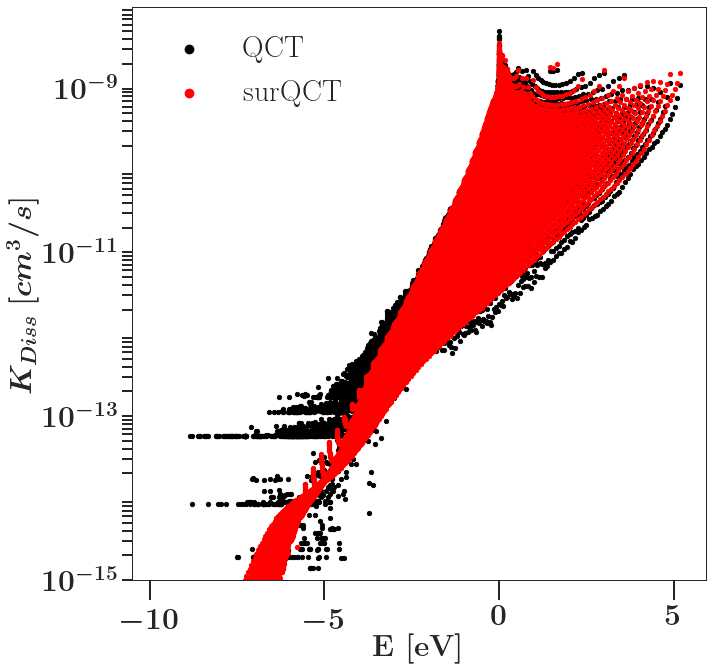

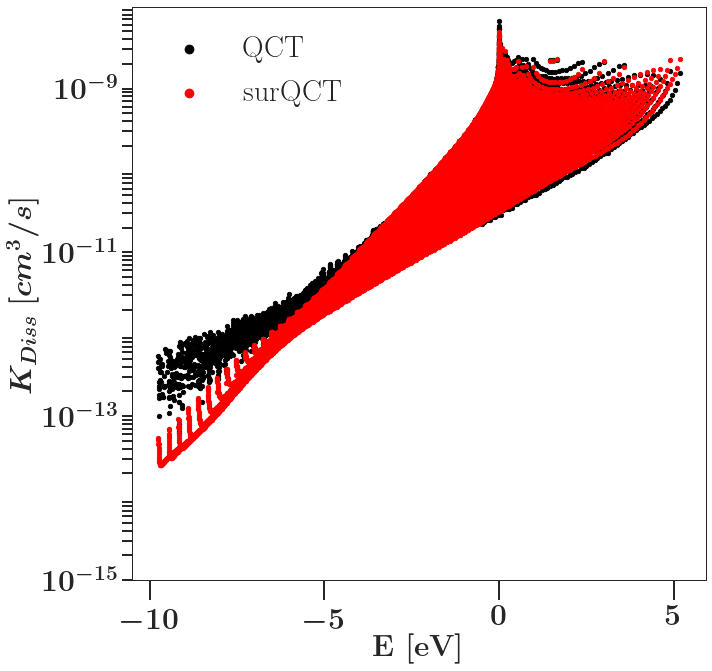

In [9]:
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec

    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    KDiss_NN             *= ScalingFact
    
    ### Plotting
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    if (KDissAll is not None):
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=20, c='k',label='QCT')
    ax.scatter(DiatData[1]['EInt'], KDiss_NN,   s=20, c='r',label='surQCT')

    # x-axis properties
    plt.xlabel('\\textbf{E [eV]}')
#     ax.set_xticks([-5,-2.5,0,2.5])
    
    # y-axis properties
    plt.yscale('log')
    plt.ylim([1.e-15, 1.e-8])    
    plt.ylabel('$K_{Diss}$ \\textbf{[}$cm^3/s$\\textbf{]}')
    ax.set_yticks([1.e-15,1.e-13,1.e-11,1.e-9])
    
    plt.legend(frameon=False,markerscale=2.0)
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    fig.tight_layout(pad=1.5) 
    plt.savefig((Figure_ME_path+System.Name+'_T'+str(TTran)+'K_KDiss.eps'), format='eps')

[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 10000K
[SurQCT]:    TTran =  20000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 20000K


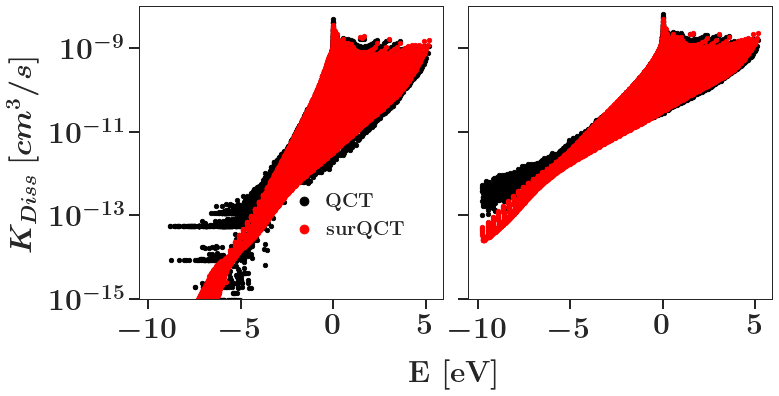

In [9]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator,LogLocator)

fig,ax = plt.subplots(1,2,figsize=(12,6),sharey=True)
iplot = 0
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec

    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    KDiss_NN             *= ScalingFact
    
    ### Plotting
    if (KDissAll is not None):
        ax[iplot].scatter(DiatData[1]['EInt'], KDissAll[:,0], s=20, c='k',label='\\textbf{QCT}')
    ax[iplot].scatter(DiatData[1]['EInt'], KDiss_NN,   s=20, c='r',label='\\textbf{surQCT}')

    # x-axis properties
    ax[iplot].set_xticks([-10,-5,0,5])
    
    # y-axis properties
    plt.yscale('log')
    plt.ylim([1.e-15, 1.e-8])    
    ax[iplot].set_yticks([1.e-15,1.e-13,1.e-11,1.e-9])

    iplot += 1

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xticks([])
plt.yticks([])

plt.xlabel('\\textbf{E [eV]}',labelpad=60)
plt.ylabel('$K_{Diss}$ \\textbf{[}$cm^3/s$\\textbf{]}',labelpad=100)
lines_labels = [ax[i].get_legend_handles_labels() for i in range(iplot-1)]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels,frameon=False,markerscale=2.0,loc = 'upper center',ncol=1,bbox_to_anchor=(0.5, 0.6),handletextpad=0.1)

#     ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
fig.tight_layout(pad=0.5) 
# plt.savefig((Figure_ME_path+System.Name+'_KDiss.pdf'), format='pdf',dpi=600)

[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 10000K


<ipython-input-11-c5edf987e09f>:13: RuntimeWarning: divide by zero encountered in log10
  sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=100, c=np.log10(KDissAll[:,0]), vmin=vmin, vmax=vmax,cmap='jet')
<ipython-input-11-c5edf987e09f>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


[SurQCT]:    TTran =  20000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 20000K


<ipython-input-11-c5edf987e09f>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


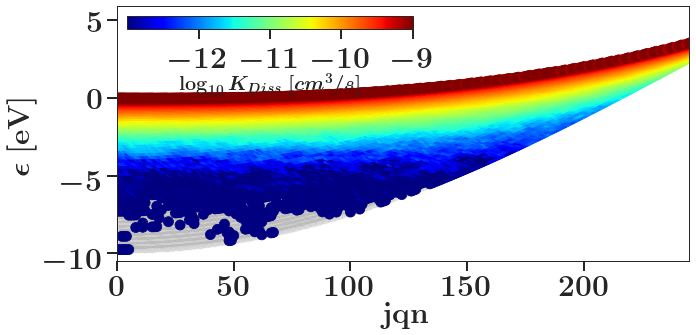

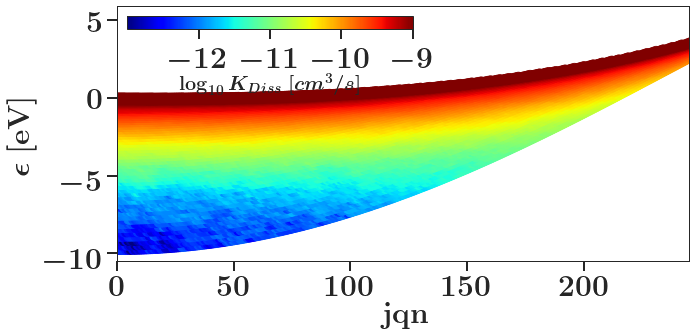

In [11]:
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    
    
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=50, c='grey',alpha=0.1)

    vmax     = -9
    vmin     = -13

    sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=100, c=np.log10(KDissAll[:,0]), vmin=vmin, vmax=vmax,cmap='jet')
    
    axs.set_xlim([DiatData[1]['jqn'].min(), 245])
#     axs.set_ylim([DiatData[1]['jqn'].min(), 200])
#     axs.set_xticks([0,10,20,30,40])
#     axs.set_yticks([0,25,50,75,100,125,150,175])

    axins1 = inset_axes(axs,
                        width="50%",  # width = 50% of parent_bbox width
                        height="5%",  # height : 5%
                        loc='upper left')
    
    cbar = fig.colorbar(sc, cax=axins1, orientation="horizontal", ticks=[-12,-11,-10,-9])
    axins1.xaxis.set_ticks_position("bottom")    
    cbar.set_label('$\log_{10}{K_{Diss}}$ \\textbf{[}$cm^3/s$\\textbf{]}',fontsize=20)

    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel('\\textbf{jqn}',labelpad=40)
    plt.ylabel('$\epsilon$ \\textbf{[eV]}',labelpad=80)
    
    
    fig.tight_layout(pad=2.0) 
    plt.savefig(('/home/venturi/WORKSPACE/SurQCT/0D/Figures/OUSD_poster/N2_T'+str(TTran)+'K_KDiss_DiatPot.pdf'), format='pdf',dpi=600)


# NON KDiss

In [12]:
Dimension   = 'nondim'
InelRunNb   = 9
ExchRunNb   = 6
DissRunNb   = 55
ReactionFlgQCT    = '1_1_0_1'
ReactionFlgSurQCT = '1_1_0_1'

import Initialize_System
import Initialize_Paths as Paths

SystName    = 'NON_UMN'
Initialize = getattr(Initialize_System,'Initialize_'+SystName)
System = Initialize()

TTranVec = [10000, 20000]

QCT_ME_path    = Paths.Workspace_path + 'Air_Database/' + System.QCTMEPath
SurQCT_ME_path = Paths.Workspace_path + 'Air_Database/Run_0D_surQCT/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

Data_ME_path   = Paths.Surqct_path + '0D/Data/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'
Figure_ME_path = Paths.Surqct_path + '0D/Figures/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

print('QCT Master Equation Path    :', QCT_ME_path)
print('SurQCT Master Equation Path :', SurQCT_ME_path)
print('Data Master Equation Path   :', Data_ME_path)
print('Figures Master Equation Path:', Figure_ME_path)


PathToHDF5File  = InputData.WORKSPACE_PATH  + '/Air_Database/HDF5_Database/NON_UMN.hdf5'
Molecules       = ['NO','NO'] 
PathToLevelsFile= [InputData.WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/NO_UMN_LogER_ro_tau_rMax.csv',
                             InputData.WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/NO_UMN_LogER_ro_tau_rMax.csv']
PathToDiatFile  = [InputData.WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/NO/UMN/Recomputed.inp',
                             InputData.WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/NO/UMN/Recomputed.inp'] 
ScalingFact      = 1


#====================================================================
# Reading Levels Info of Initial and Final Molecules
NMolecules         = len(PathToLevelsFile)
LevelsData = []
DiatData   = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(PathToDiatFile[iMol], Molecules[iMol], np.array(TTranVec), np.array(TTranVec))
    DiatData.append(DiatDataTemp)

    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)


QCT Master Equation Path    : /home/venturi/WORKSPACE/Air_Database/Run_0D/
SurQCT Master Equation Path : /home/venturi/WORKSPACE/Air_Database/Run_0D_surQCT/nondim_RunI9_E6_D55/
Data Master Equation Path   : /home/venturi/WORKSPACE/SurQCT/0D/Data/NON_UMN/nondim_RunI9_E6_D55/
Figures Master Equation Path: /home/venturi/WORKSPACE/SurQCT/0D/Figures/NON_UMN/nondim_RunI9_E6_D55/
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/NO_UMN_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/NO/UMN/Recomputed.inp
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/NO_UMN_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/NO/UMN/Recomputed.inp


[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/NON_UMN.hdf5 for Excitation Rates at Temperature 10000K


findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


[SurQCT]:    TTran =  20000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/NON_UMN.hdf5 for Excitation Rates at Temperature 20000K


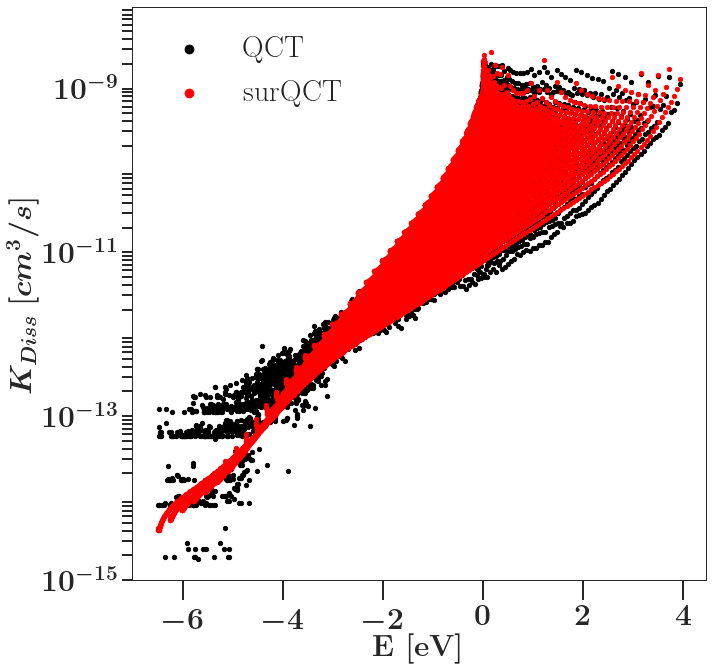

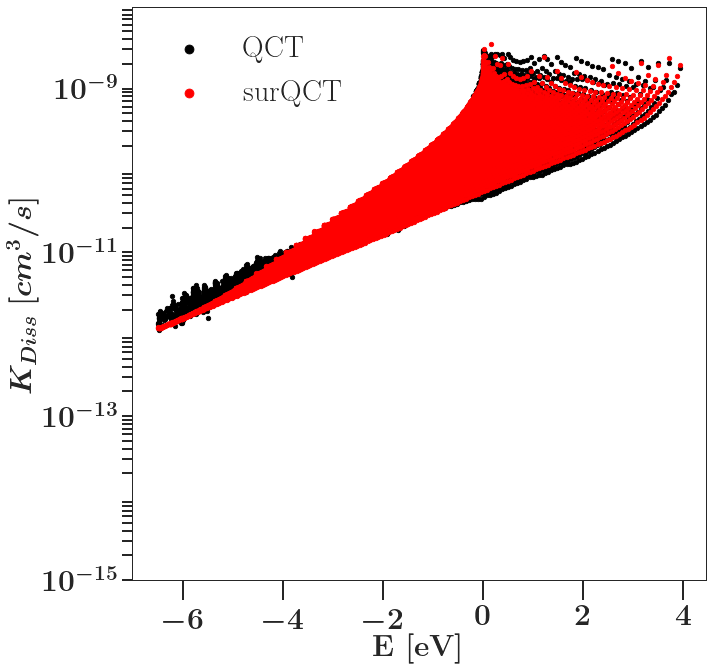

In [11]:
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec

    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    KDiss_NN             *= ScalingFact
    
    ### Plotting
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    if (KDissAll is not None):
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=20, c='k',label='QCT')
    ax.scatter(DiatData[1]['EInt'], KDiss_NN,   s=20, c='r',label='surQCT')

    # x-axis properties
    plt.xlabel('\\textbf{E [eV]}')
#     ax.set_xticks([-5,-2.5,0,2.5])
    
    # y-axis properties
    plt.yscale('log')
    plt.ylim([1.e-15, 1.e-8])    
    plt.ylabel('$K_{Diss}$ \\textbf{[}$cm^3/s$\\textbf{]}')
    ax.set_yticks([1.e-15,1.e-13,1.e-11,1.e-9])
    
    plt.legend(frameon=False,markerscale=2.0)
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    fig.tight_layout(pad=1.5) 
    plt.savefig((Figure_ME_path+System.Name+'_T'+str(TTran)+'K_KDiss.pdf'), format='pdf',dpi=600)

[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/NON_UMN.hdf5 for Excitation Rates at Temperature 10000K
[SurQCT]:    TTran =  20000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/NON_UMN.hdf5 for Excitation Rates at Temperature 20000K


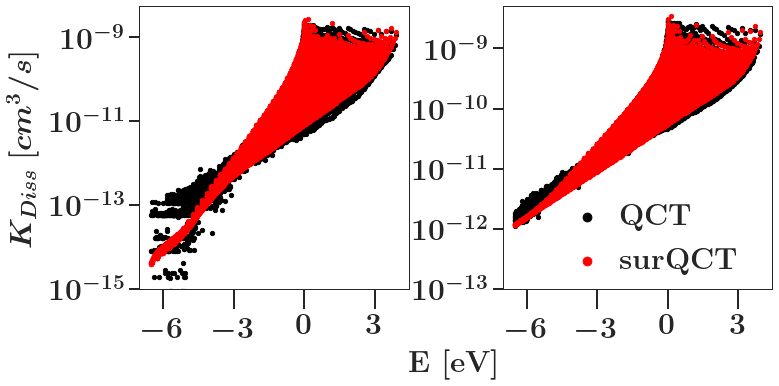

In [27]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator,LogLocator)

fig,ax = plt.subplots(1,2,figsize=(12,6))
iplot = 0
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec

    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    KDiss_NN             *= ScalingFact
    
    ### Plotting
    if (KDissAll is not None):
        ax[iplot].scatter(DiatData[1]['EInt'], KDissAll[:,0], s=20, c='k',label='\\textbf{QCT}')
    ax[iplot].scatter(DiatData[1]['EInt'], KDiss_NN,   s=20, c='r',label='\\textbf{surQCT}')

    # x-axis properties
    ax[iplot].set_xticks([-6,-3,0,3])
    ax[iplot].set_yscale('log')

    # y-axis properties
    plt.yscale('log')
    plt.ylim([1.e-15, 1.e-8])    

    iplot += 1

ax[0].set_yticks([1.e-15,1.e-13,1.e-11,1.e-9])
ax[1].set_ylim([1e-15,1e-8])
ax[1].set_yticks([1.e-13,1.e-12,1.e-11,1.e-10,1.e-9])
ax[1].set_ylim([1e-13,5e-9])

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xticks([])
plt.yticks([])

plt.xlabel('\\textbf{E [eV]}',labelpad=60)
plt.ylabel('$K_{Diss}$ \\textbf{[}$cm^3/s$\\textbf{]}',labelpad=100)
lines_labels = [ax[i].get_legend_handles_labels() for i in range(iplot-1)]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels,frameon=False,markerscale=2.0,loc = 'upper center',ncol=1,bbox_to_anchor=(0.85, 0.6),handletextpad=0.1)

#     ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
fig.tight_layout(pad=0.5) 
plt.savefig((Figure_ME_path+System.Name+'_KDiss.pdf'), format='pdf',dpi=600)

[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/NON_UMN.hdf5 for Excitation Rates at Temperature 10000K


<ipython-input-16-3022f10ff6b3>:13: RuntimeWarning: divide by zero encountered in log10
  sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=100, c=np.log10(KDissAll[:,0]), vmin=vmin, vmax=vmax,cmap='jet')
<ipython-input-16-3022f10ff6b3>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


[SurQCT]:    TTran =  20000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/NON_UMN.hdf5 for Excitation Rates at Temperature 20000K


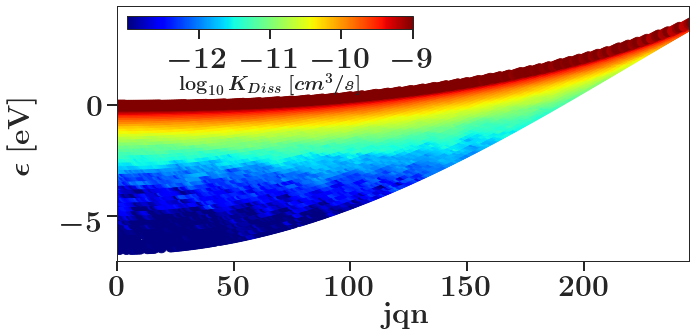

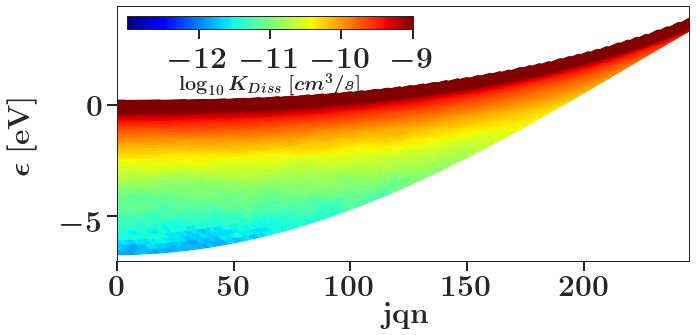

In [16]:
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    
    
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=50, c='grey',alpha=0.1)

    vmax     = -9
    vmin     = -13

    sc = axs.scatter(DiatData[1]['jqn'], DiatData[1]['EInt'],s=100, c=np.log10(KDissAll[:,0]), vmin=vmin, vmax=vmax,cmap='jet')
    
    axs.set_xlim([DiatData[1]['jqn'].min(), 245])
#     axs.set_ylim([DiatData[1]['jqn'].min(), 200])
#     axs.set_xticks([0,10,20,30,40])
#     axs.set_yticks([0,25,50,75,100,125,150,175])

    axins1 = inset_axes(axs,
                        width="50%",  # width = 50% of parent_bbox width
                        height="5%",  # height : 5%
                        loc='upper left')
    
    cbar = fig.colorbar(sc, cax=axins1, orientation="horizontal", ticks=[-12,-11,-10,-9])
    axins1.xaxis.set_ticks_position("bottom")    
    cbar.set_label('$\log_{10}{K_{Diss}}$ \\textbf{[}$cm^3/s$\\textbf{]}',fontsize=20)

    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel('\\textbf{jqn}',labelpad=40)
    plt.ylabel('$\epsilon$ \\textbf{[eV]}',labelpad=80)
    
    
    fig.tight_layout(pad=2.0) 
    plt.savefig(('/home/venturi/WORKSPACE/SurQCT/0D/Figures/OUSD_poster/NO_T'+str(TTran)+'K_KDiss_DiatPot.pdf'), format='pdf',dpi=600)
